In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from keras import layers
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from libs.setutils import load_sets
from libs.analizelib import find_threshold,get_predictions,analize_predictions

In [2]:
anomaly = [8] # the model was trained to recognize 8s as anomalies
((x_train, x_test),\
    (anomaly_set_train, nominal_set_train, train_labels),\
    (anomaly_set_test, nominal_set_test, test_labels)) = load_sets(anomaly)

In [3]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(512, activation='relu')(input_img)
encoded = layers.Dense(384, activation='relu')(encoded)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(192, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(192, activation='relu')(decoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(384, activation='relu')(decoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded)

In [4]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
loss_function = keras.losses.mean_squared_error
history = autoencoder.fit(nominal_set_train, nominal_set_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(nominal_set_test, nominal_set_test))

Epoch 1/50
212/212 [==============================] - 4s 19ms/step - loss: 0.0689 - val_loss: 0.0531
Epoch 2/50
212/212 [==============================] - 4s 17ms/step - loss: 0.0412 - val_loss: 0.0329
Epoch 3/50
212/212 [==============================] - 4s 18ms/step - loss: 0.0299 - val_loss: 0.0268
Epoch 4/50
212/212 [==============================] - 4s 20ms/step - loss: 0.0256 - val_loss: 0.0243
Epoch 5/50
212/212 [==============================] - 4s 19ms/step - loss: 0.0235 - val_loss: 0.0227
Epoch 6/50
212/212 [==============================] - 4s 18ms/step - loss: 0.0222 - val_loss: 0.0220
Epoch 7/50
212/212 [==============================] - 4s 20ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 8/50
212/212 [==============================] - 4s 18ms/step - loss: 0.0197 - val_loss: 0.0194
Epoch 9/50
212/212 [==============================] - 4s 17ms/step - loss: 0.0186 - val_loss: 0.0183
Epoch 10/50
212/212 [==============================] - 4s 17ms/step - loss: 0.0175 - val_lo

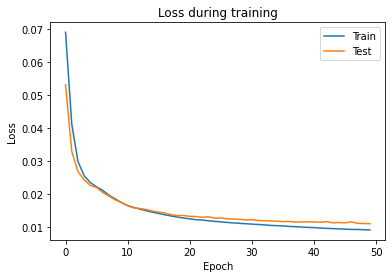

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [6]:
from datetime import datetime

now = datetime.now()
now = now.strftime("%D.%H:%M:%S").replace("/","_")
autoencoder.save(f"./models/{now}/model")
print(f"Model saved in ./models/{now}/model")

INFO:tensorflow:Assets written to: ./models/03_11_22.19:56:15/model/assets
Model saved in ./models/03_11_22.19:56:15/model


In [7]:
def find_best_threshold(test_predictions, testing_set, testing_labels):
    maxi, maxratio, maxa, maxn = 0,0,0,0
    for i in range(0, 50, 1):
        start=92
        increment = i/10
        threshold = find_threshold(autoencoder.predict(nominal_set_test), nominal_set_test, loss_function, start+increment)
        preds = get_predictions(test_predictions, testing_set, threshold, loss_function)

        detected_anomalies,\
        undetected_anomalies,\
        incorrecly_detected_anomalies,\
        correctly_detected_nominal,\
        num_anomalies,\
        num_nominals = analize_predictions(preds, testing_labels)

        ratio = round(detected_anomalies/num_anomalies*100,2)+round(correctly_detected_nominal/num_nominals*100,2)
        ratio/=2
        a = round(detected_anomalies/num_anomalies*100,2)
        n = round(correctly_detected_nominal/num_nominals*100,2)
        if ratio>maxratio and abs(a-n)<2: # i want to maximize the accuracy but at the same time have two similar accuracies
            maxi = start+increment
            maxratio = ratio
    with open(f"./models/{now}/model/threshold.txt", "w") as thresh_file:
        thresh_file.write(str(find_threshold(autoencoder.predict(nominal_set_test),nominal_set_test,loss_function,maxi)))
        print(f"Threshold file created, best percentile: {maxi}")

In [8]:
find_best_threshold(autoencoder.predict(x_test), x_test, test_labels)

Threshold file created, best percentile: 94.6
